In [1]:
!pip install transformers torch datasets rouge-score nltk streamlit pyngrok
!pip install accelerate -U

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 115.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.0 MB/s eta 0:00:0000:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-no

In [2]:
# Import libraries and setup
import pandas as pd
import numpy as np
import torch
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

print("Setup complete!")



2025-06-22 16:43:29.859923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750610610.061913      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750610610.121204      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete!


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
import transformers
print(transformers.__version__)


4.51.3


# Data Loading and Visualization

In [4]:
dataset_path = '/kaggle/input/medquad-csv/medquad.csv'
df = pd.read_csv(dataset_path)

# Display info
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns}")
print("\nFirst few rows:")
print(df.head())

print(f"Questions: {len(df)} total")
print(f"Sample question: {df['question'].iloc[0]}")
print(f"Sample answer: {df['answer'].iloc[0][:100]}...")


Dataset shape: (16412, 4)
Columns: Index(['question', 'answer', 'source', 'focus_area'], dtype='object')

First few rows:
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Questions: 16412 total
Sample question: What is (are) Glaucoma ?
Sample answer

In [5]:
print(f"Exact duplicates: {df.duplicated().sum()}") 

Exact duplicates: 48


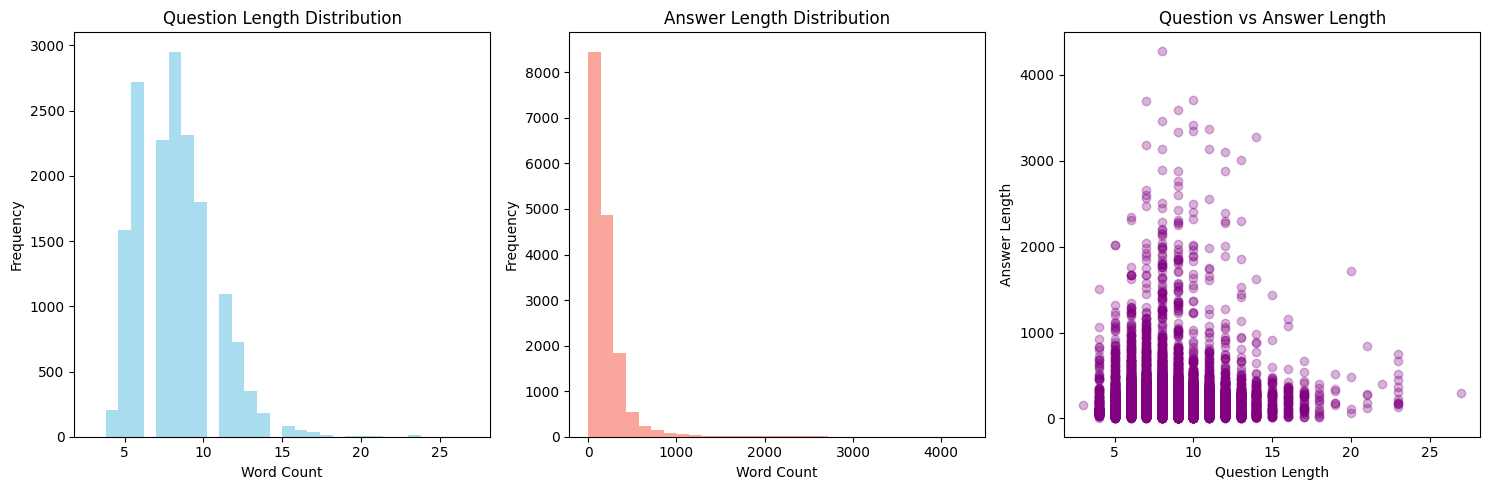

In [6]:
# Visualizations
if 'q_word_len' not in df.columns:
    df['q_word_len'] = df['question'].apply(lambda x: len(str(x).split()))
if 'a_word_len' not in df.columns:
    df['a_word_len'] = df['answer'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['q_word_len'], bins=30, color='skyblue', alpha=0.7)
plt.title('Question Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['a_word_len'], bins=30, color='salmon', alpha=0.7)
plt.title('Answer Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.scatter(df['q_word_len'], df['a_word_len'], alpha=0.3, color='purple')
plt.title('Question vs Answer Length')
plt.xlabel('Question Length')
plt.ylabel('Answer Length')

plt.tight_layout()
plt.show()

# Preprocessing and Analysis

In [7]:
data_splitting = '''\
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os
from sklearn.utils import resample

def balance_classes(df, max_samples_per_class=30):
    grouped = df.groupby('focus_area')
    balanced = []
    for name, group in grouped:
        if len(group) > max_samples_per_class:
            balanced.append(group.sample(max_samples_per_class, random_state=42))
        else:
            balanced.append(group)
    return pd.concat(balanced).sample(frac=1, random_state=42)

def medical_split(df):
    df = df.dropna(subset=['question', 'answer', 'focus_area'])
    df = df[df['focus_area'] != 'UNKNOWN']
    
    def get_question_type(q):
        q = q.lower()
        if 'what is' in q or 'define' in q: return 'DEF'
        elif 'symptom' in q or 'sign' in q: return 'SX'
        elif 'treat' in q or 'therapy' in q: return 'TX'
        elif 'diagnos' in q or 'test for' in q: return 'DX'
        else: return 'CLS'
    
    df['q_type'] = df['question'].apply(get_question_type)
    
    train, temp = train_test_split(
        df,
        test_size=0.3,
        stratify=df['q_type'],
        random_state=42
    )
    
    val, test = train_test_split(
        temp,
        test_size=0.5,
        stratify=temp['q_type'],
        random_state=42
    )
    
    print("\\n=== Balanced Splits ===")
    for name, split in [('TRAIN', train), ('VAL', val), ('TEST', test)]:
        print(f"\\n{name}: {len(split)} samples")
        print(split['q_type'].value_counts())
    
    return train, val, test

if __name__ == "__main__":
    df = pd.read_csv('/kaggle/input/medquad-csv/medquad.csv')
    train_df, val_df, test_df = medical_split(df)
    
    os.makedirs("/kaggle/working/splits", exist_ok=True)
    train_df.to_csv("/kaggle/working/splits/train.csv", index=False)
    val_df.to_csv("/kaggle/working/splits/val.csv", index=False)
    test_df.to_csv("/kaggle/working/splits/test.csv", index=False)
    print("\\nSplits saved!")
'''

with open('/kaggle/working/data_split.py', 'w') as f:
    f.write(data_splitting)

print("Saved data_split.py")


Saved data_split.py


In [8]:
!python /kaggle/working/data_split.py


=== Balanced Splits ===

TRAIN: 11475 samples
q_type
CLS    4156
DEF    3216
SX     1924
TX     1721
DX      458
Name: count, dtype: int64

VAL: 2459 samples
q_type
CLS    890
DEF    690
SX     412
TX     369
DX      98
Name: count, dtype: int64

TEST: 2459 samples
q_type
CLS    891
DEF    689
SX     413
TX     368
DX      98
Name: count, dtype: int64

Splits saved!


In [9]:
preprocessing_code = '''\
import pandas as pd
import torch
from transformers import BertTokenizer
from transformers.tokenization_utils_base import BatchEncoding
import os
import re
from sklearn.utils import resample
import numpy as np

torch.serialization._import_dotted_name = lambda name: eval(name)
torch.serialization.add_safe_globals([BatchEncoding])

class MedicalPreprocessor:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained(
            "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
            add_prefix_space=True
        )
        self.label_map = {"DEF": 0, "SX": 1, "TX": 2, "DX": 3, "CLS": 4}
    
    def clean_text(self, text):
        text = re.sub(r'\\[.*?\\]|\\(.*?\\)', '', text)
        text = re.sub(r'\\b(e\\.g|i\\.e|etc)\\.?\\b', '', text, flags=re.IGNORECASE)
        return ' '.join(text.split()).strip()
    
    def preprocess_split(self, df, split_name):
        print(f"\\nProcessing {split_name}...")
        assert set(df['q_type'].unique()).issubset(self.label_map.keys())
        
        df['label'] = df['q_type'].map(self.label_map)
        texts = (df['q_type'] + " " + df['question'].str.lower()).tolist()
        
        encodings = self.tokenizer(
            texts,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        encodings['labels'] = torch.tensor(df['label'].values)
        
        print("\\nClass Distribution:")
        for cls, name in self.label_map.items():
            count = (encodings['labels'] == name).sum().item()
            print(f"{cls}: {count} samples")
        
        return encodings

if __name__ == "__main__":
    preprocessor = MedicalPreprocessor()
    os.makedirs("/kaggle/working/tokenized", exist_ok=True)
    
    for split in ["train", "val", "test"]:
        try:
            df = pd.read_csv(f"/kaggle/working/splits/{split}.csv")
            encodings = preprocessor.preprocess_split(df, split)
            torch.save(
                encodings,
                f"/kaggle/working/tokenized/{split}_encodings.pt",
                _use_new_zipfile_serialization=True
            )
            print(f"Saved {split} ({len(df)} samples)")
        except Exception as e:
            print(f"Error: {str(e)}")
'''

with open('/kaggle/working/preprocessing.py', 'w') as f:
    f.write(preprocessing_code)

print("Saved preprocessing.py")


Saved preprocessing.py


In [10]:
!python /kaggle/working/preprocessing.py


tokenizer_config.json: 100%|██████████████████| 28.0/28.0 [00:00<00:00, 207kB/s]
vocab.txt: 100%|█████████████████████████████| 225k/225k [00:00<00:00, 6.98MB/s]
config.json: 100%|█████████████████████████████| 385/385 [00:00<00:00, 3.24MB/s]

Processing train...

Class Distribution:
DEF: 3216 samples
SX: 1924 samples
TX: 1721 samples
DX: 458 samples
CLS: 4156 samples
Saved train (11475 samples)

Processing val...

Class Distribution:
DEF: 690 samples
SX: 412 samples
TX: 369 samples
DX: 98 samples
CLS: 890 samples
Saved val (2459 samples)

Processing test...

Class Distribution:
DEF: 689 samples
SX: 413 samples
TX: 368 samples
DX: 98 samples
CLS: 891 samples
Saved test (2459 samples)


# Training

In [26]:
training_code = """\
import torch
from transformers import (
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from transformers.tokenization_utils_base import BatchEncoding
import numpy as np
import os
from sklearn.metrics import f1_score

# Register BatchEncoding for torch.load (PyTorch 2.6+)
torch.serialization.add_safe_globals([BatchEncoding])

# Environment setup
os.environ['WANDB_DISABLED'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use only 1 GPU to save memory

class MedQADataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.encodings['labels'][idx]
        }

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        'accuracy': np.mean(predictions == labels),
        'f1_macro': f1_score(labels, predictions, average='macro')
    }

def load_encodings(path):
    try:
        return torch.load(path, weights_only=False)
    except:
        return torch.load(path)

def train_medquad():
    print('\\n=== Loading Data ===')
    train_data = load_encodings('/kaggle/working/tokenized/train_encodings.pt')
    val_data = load_encodings('/kaggle/working/tokenized/val_encodings.pt')
    
    train_dataset = MedQADataset(train_data)
    val_dataset = MedQADataset(val_data)
    print(f'Train: {len(train_dataset)} | Val: {len(val_dataset)} samples')

    print('\\n=== Model Setup ===')
    model = BertForSequenceClassification.from_pretrained(
        'microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract',
        num_labels=5,
        ignore_mismatched_sizes=True
    )
    
    # Backward-compatible TrainingArguments setup
    try:
        args = TrainingArguments(
            output_dir='/kaggle/working/output',
            per_device_train_batch_size=8,
            per_device_eval_batch_size=16,
            num_train_epochs=5,
            learning_rate=2e-5,
            warmup_ratio=0.1,
            weight_decay=0.01,
            max_grad_norm=1.0,
            fp16=True,
            eval_strategy='steps',  # older versions
            eval_steps=200,
            save_steps=200,
            load_best_model_at_end=True,
            metric_for_best_model='f1_macro',
            logging_steps=50,
            report_to='none',
            gradient_accumulation_steps=2,
            dataloader_pin_memory=False,
            dataloader_num_workers=2
        )
        print('Using eval_strategy="steps"')
    except TypeError:
        try:
            args = TrainingArguments(
                output_dir='/kaggle/working/output',
                per_device_train_batch_size=8,
                per_device_eval_batch_size=16,
                num_train_epochs=5,
                learning_rate=2e-5,
                warmup_ratio=0.1,
                weight_decay=0.01,
                max_grad_norm=1.0,
                fp16=True,
                evaluation_strategy='steps',  # newer versions
                eval_steps=200,
                save_steps=200,
                load_best_model_at_end=True,
                metric_for_best_model='f1_macro',
                logging_steps=50,
                report_to='none',
                gradient_accumulation_steps=2,
                dataloader_pin_memory=False,
                dataloader_num_workers=2
            )
            print('Using evaluation_strategy="steps"')
        except Exception as e:
            print(f'Error creating TrainingArguments: {e}')
            args = TrainingArguments(
                output_dir='/kaggle/working/output',
                per_device_train_batch_size=8,
                per_device_eval_batch_size=16,
                num_train_epochs=5,
                learning_rate=2e-5,
                warmup_ratio=0.1,
                weight_decay=0.01,
                max_grad_norm=1.0,
                fp16=True,
                gradient_accumulation_steps=2,
                dataloader_pin_memory=False,
                dataloader_num_workers=2
            )
            print('Using basic TrainingArguments without eval strategy')

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    print('\\n=== Training ===')
    trainer.train()
    
    # Save model & tokenizer
    model.save_pretrained('/kaggle/working/final_model', save_tokenizer=True)
    print('Training complete!')

if __name__ == '__main__':
    train_medquad()
"""

with open('/kaggle/working/train.py', 'w') as f:
    f.write(training_code)

print('Saved train.py')


Saved train.py


In [27]:
!python /kaggle/working/train.py

2025-06-22 17:36:25.817532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750613785.840364    1810 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750613785.847410    1810 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

=== Loading Data ===
Train: 11475 | Val: 2459 samples

=== Model Setup ===
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using eval_strategy="steps"

=== 

In [13]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [29]:
evaluation_code = '''\
import torch
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
)
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix
)
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

class MedQuadEvaluator:
    def __init__(self, model_path="/kaggle/working/final_model"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load tokenizer - fallback to original model if not found
        try:
            self.tokenizer = BertTokenizer.from_pretrained(model_path)
        except OSError:
            print(f"Tokenizer not found in {model_path}, using original model's tokenizer")
            self.tokenizer = BertTokenizer.from_pretrained(
                "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
            )
        
        # Load model
        self.model = BertForSequenceClassification.from_pretrained(model_path).to(self.device)
        self.model.eval()
        
        self.label_map = {
            "DEF": 0,  # Definitions
            "SX": 1,   # Symptoms
            "TX": 2,   # Treatments
            "DX": 3,   # Diagnosis
            "CLS": 4   # General
        }
        self.inverse_map = {v: k for k, v in self.label_map.items()}
    
    def load_test_data(self, test_path="/kaggle/working/splits/test.csv"):
        """Load and clean test data"""
        if not os.path.exists(test_path):
            raise FileNotFoundError(f"Test file not found at {test_path}")
            
        df = pd.read_csv(test_path)
        df = df.dropna(subset=['question', 'answer', 'q_type'])
        return df
    
    def batch_predict(self, texts, batch_size=32):
        """Run batched predictions with progress bar"""
        predictions = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
            batch = texts[i:i+batch_size]
            inputs = self.tokenizer(
                batch,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            ).to(self.device)
            
            with torch.no_grad():
                outputs = self.model(**inputs)
            predictions.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
        return predictions
    
    def evaluate(self):
        """Run full evaluation pipeline"""
        try:
            test_df = self.load_test_data()
            
            # Prepare data - maintain same format as training
            texts = (test_df['q_type'] + " " + test_df['question'].str.lower()).tolist()
            y_true = test_df['q_type'].map(self.label_map).values
            
            # Predict
            y_pred = self.batch_predict(texts)
            
            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            f1_macro = f1_score(y_true, y_pred, average='macro')
            f1_weighted = f1_score(y_true, y_pred, average='weighted')
            
            print("\\n=== Evaluation Results ===")
            print(f"Accuracy: {accuracy:.2%}")
            print(f"Macro F1: {f1_macro:.2%}")
            print(f"Weighted F1: {f1_weighted:.2%}")
            
            # Detailed reports
            target_names = list(self.label_map.keys())
            print("\\nClassification Report:")
            print(classification_report(
                y_true, y_pred,
                target_names=target_names,
                digits=4
            ))
            
            print("\\nConfusion Matrix:")
            print(confusion_matrix(y_true, y_pred))
            
            return {
                'accuracy': accuracy,
                'f1_macro': f1_macro,
                'f1_weighted': f1_weighted,
                'y_true': y_true,
                'y_pred': y_pred
            }
            
        except Exception as e:
            print(f"\\nError during evaluation: {str(e)}")
            return None

if __name__ == "__main__":
    print("=== Starting Evaluation ===")
    evaluator = MedQuadEvaluator()
    results = evaluator.evaluate()
    
    if results:
        print("\\nEvaluation completed successfully!")
    else:
        print("\\nEvaluation failed")
'''

with open('/kaggle/working/eval.py', 'w') as f:
    f.write(evaluation_code)

print("Saved eval.py")


Saved eval.py


In [30]:
!python /kaggle/working/eval.py


2025-06-22 17:53:28.784220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750614808.808270    5716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750614808.815772    5716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
=== Starting Evaluation ===
Tokenizer not found in /kaggle/working/final_model, using original model's tokenizer
Predicting: 100%|███████████████████████████████| 77/77 [00:15<00:00,  5.10it/s]

=== Evaluation Results ===
Accuracy: 99.96%
Macro F1: 99.87%
Weighted F1: 99.96%

Classification Report:
              precision    recall  f1-score   support

         DEF     1.0000    1.0000    1.0000       689
          SX     1.0000    1